## 加载图像

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_path='../data/detection/2008_007442.jpg'
annotation_path='../data/detection/2008_007442.npy'
im=cv2.imread(image_path)[...,::-1]
boxes=np.load(annotation_path)
plt.imshow(im)
boxes

array([[166.,  57., 205., 165.],
       [165., 265., 200., 373.],
       [148., 104., 171., 118.],
       [146., 312., 169., 324.]])

## functions

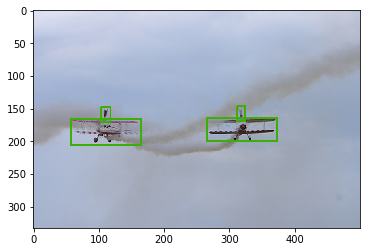

In [2]:
import random
def random_color():
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

def draw_rect(image, boxes, class_names=None, color=None):
    """

    :param image:
    :param boxes:
    :param class_names:
    :param color:
    :return:
    """
    im = image.copy()
    boxes = boxes[:, :4].astype(np.int)
    if not color:
        color = random_color()
    for i in range(len(boxes)):
        y1, x1, y2, x2 = boxes[i]
        im = cv2.rectangle(im, (x1, y1), (x2, y2), color, int(max(im.shape[:2]) / 200))
        if class_names is not None:
            im = cv2.addText(im, class_names[i], (x1, y1 + 8), cv2.FONT_HERSHEY_SIMPLEX,
                             1, (255, 255, 255))
    return im
plt.imshow(draw_rect(im,boxes))

In [3]:
def center_filter(gt_boxes, rect):
    """
    过滤边框中心点不在矩形框内的边框
    :param gt_boxes: [N,(y1,x1,y2,x2)]
    :param rect: [y1,x1,y2,x2]
    :return keep: 保留的边框索引号
    """
    # gt boxes中心点坐标
    ctr_x = np.sum(gt_boxes[:, [1, 3]], axis=1) / 2.  # [N]
    ctr_y = np.sum(gt_boxes[:, [0, 2]], axis=1) / 2.  # [N]
    y1, x1, y2, x2 = rect  # 矩形框坐标

    keep = np.logical_and(np.logical_and(np.logical_and(ctr_x >= x1, ctr_x <= x2),
                                         ctr_y >= y1),
                          ctr_y <= y2)
    return keep


In [4]:
def iou_nvn(boxes_a, boxes_b):
    """
    numpy 计算IoU
    :param boxes_a: [N,4]
    :param boxes_b: [M,4]
    :return:  IoU [N,M]
    """
    # 扩维
    boxes_a = np.expand_dims(boxes_a, axis=1)  # (N,1,4)
    boxes_b = np.expand_dims(boxes_b, axis=0)  # (1,M,4)

    # 分别计算高度和宽度的交集
    overlap_h = np.maximum(0.0,
                           np.minimum(boxes_a[..., 2], boxes_b[..., 2]) -
                           np.maximum(boxes_a[..., 0], boxes_b[..., 0]))  # (N,M)

    overlap_w = np.maximum(0.0,
                           np.minimum(boxes_a[..., 3], boxes_b[..., 3]) -
                           np.maximum(boxes_a[..., 1], boxes_b[..., 1]))  # (N,M)

    # 交集
    overlap = overlap_w * overlap_h

    # 计算面积
    area_a = (boxes_a[..., 2] - boxes_a[..., 0]) * (boxes_a[..., 3] - boxes_a[..., 1])
    area_b = (boxes_b[..., 2] - boxes_b[..., 0]) * (boxes_b[..., 3] - boxes_b[..., 1])

    # 交并比
    return overlap / (area_a + area_b - overlap)


def iou_1vn(box, boxes):
    """
    numpy 计算IoU,一对多
    :param box: [4]
    :param boxes: [N,4]
    :return iou: [N]
    """
    iou = iou_nvn(box[np.newaxis, :], boxes)  # [1,N]
    return iou[0]

def iou_filter(gt_boxes, rect, min_iou):
    """
    过滤 与矩形框iou小于阈值的边框
    :param gt_boxes: [N,(y1,x1,y2,x2)]
    :param rect: [y1,x1,y2,x2]
    :param min_iou:
    :return keep: 保留的边框索引号
    """
    iou = iou_1vn(np.array(rect), gt_boxes)  # [N]
    return iou >= min_iou

## resize

In [5]:
class Resize(object):

    def __init__(self, height, width, interpolation_mode=cv2.INTER_LINEAR):
        """

        :param height:
        :param width:
        :param interpolation_mode: An integer that denotes a valid
                OpenCV interpolation mode. For example, integers 0 through 5 are
                valid interpolation modes.
        """
        self.out_height = height
        self.out_width = width
        self.interpolation_mode = interpolation_mode

    def __call__(self, image, gt_boxes=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: GT boxes [N,(y1,x1,y2,x2)]
        :return image:
        :return boxes:
        """

        img_height, img_width = image.shape[:2]

        image = cv2.resize(image,
                           dsize=(self.out_width, self.out_height),
                           interpolation=self.interpolation_mode)
        if gt_boxes is None:
            return image

        boxes = gt_boxes.copy()
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * (self.out_height / img_height)
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * (self.out_width / img_width)
        return image, boxes


array([[ 99.6996997 ,  34.2       , 123.12312312,  99.        ],
       [ 99.0990991 , 159.        , 120.12012012, 223.8       ],
       [ 88.88888889,  62.4       , 102.7027027 ,  70.8       ],
       [ 87.68768769, 187.2       , 101.5015015 , 194.4       ]])

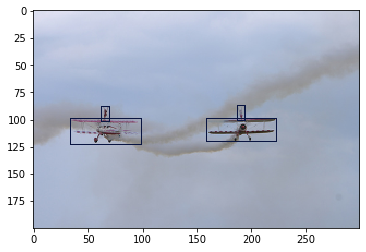

In [6]:
img,bb=Resize(200,300)(im.copy(),boxes)
plt.imshow(draw_rect(img,bb))
bb

## Flip

In [7]:
class Flip:
    """
    水平或者垂直翻转图像
    """

    def __init__(self, dim='horizontal'):
        """

        :param dim: 翻转维度；horizontal-水平，vertical-垂直
        """
        self.dim = dim

    def __call__(self, image, gt_boxes=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: GT boxes [N,(y1,x1,y2,x2)]
        :return:
        """
        img_height, img_width = image.shape[:2]

        if self.dim == 'horizontal':  # 水平翻转
            image = image[:, ::-1]
            if gt_boxes is None:
                return image

            boxes = np.copy(gt_boxes)
            boxes[:, [1, 3]] = img_width - boxes[:, [3, 1]]
            return image, boxes
        else:  # 垂直翻转
            image = image[::-1]
            if gt_boxes is None:
                return image

            boxes = np.copy(gt_boxes)
            boxes[:, [0, 2]] = img_height - boxes[:, [2, 0]]
            return image, boxes
class HorizontalFlip(Flip):
    def __init__(self):
        super(HorizontalFlip, self).__init__(dim='horizontal')


class VerticalFlip(Flip):
    def __init__(self):
        super(VerticalFlip, self).__init__(dim='vertical')

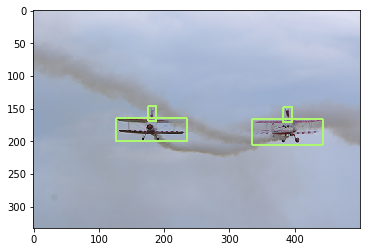

In [17]:
img,bb=HorizontalFlip()(im.copy(),boxes)
plt.imshow(draw_rect(img,bb))

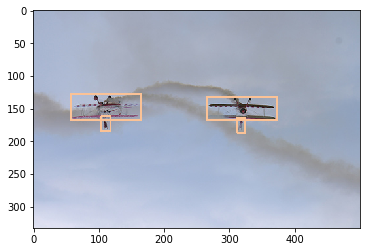

In [16]:
img,bb=VerticalFlip()(im.copy(),boxes)
plt.imshow(draw_rect(img,bb))

## Translate

In [51]:
class Translate(object):
    """
    平移图像
    """

    def __init__(self, dy, dx, clip_boxes=True, background=(0, 0, 0)):
        """
        
        :param dy: 高度方向移动因子
        :param dx: 宽度方向移动因子
        :param clip_boxes: 裁剪边框到图像内
        :param background: 填充色
        """

        self.dy_rel = dy
        self.dx_rel = dx
        self.clip_boxes = clip_boxes
        self.background = background

    def __call__(self, image, gt_boxes=None, labels=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: GT boxes [N,(y1,x1,y2,x2)]
        :param labels: [N]
        :return:
        """

        img_height, img_width = image.shape[:2]

        dy_abs = img_height * self.dy_rel
        dx_abs = img_width * self.dx_rel
        matrix = np.float32([[1, 0, dx_abs],
                             [0, 1, dy_abs]])

        # 平移图像
        image = cv2.warpAffine(image,
                               M=matrix,
                               dsize=(img_width, img_height),
                               borderMode=cv2.BORDER_CONSTANT,
                               borderValue=self.background)

        if gt_boxes is None:
            return image

        # 边框坐标对应平移
        boxes = np.copy(gt_boxes)
        boxes[:, [1, 3]] += dx_abs
        boxes[:, [0, 2]] += dy_abs

        # 过滤中心点不在图像内的边框
        keep = center_filter(boxes, [0, 0, img_height, img_width])
        boxes = boxes[keep]
        labels = labels[keep]

        if self.clip_boxes:
            boxes[:, [1, 3]] = np.clip(boxes[:, [1, 3]], a_min=0, a_max=img_width)
            boxes[:, [0, 2]] = np.clip(boxes[:, [0, 2]], a_min=0, a_max=img_height)

        return image, boxes, labels

array([[198.3, 140. , 233.3, 248. ],
       [179.3, 187. , 202.3, 199. ]])

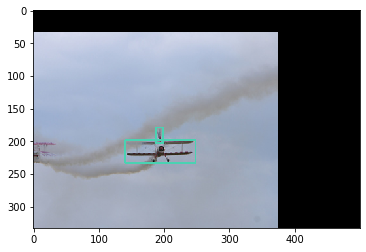

In [55]:
img,bb,_=Translate(0.1,-0.25,clip_boxes=False)(im.copy(),boxes,np.ones_like(boxes[:,0]))
plt.imshow(draw_rect(img,bb))
bb

## Scale

In [57]:
class Scale(object):
    """
    缩放图像,图像尺寸不变,镜头拉近、拉远
    """

    def __init__(self,
                 factor,
                 clip_boxes=True,
                 background=(0, 0, 0)):
        """

        :param factor: 大于1拉近距离放大图像;小于1拉远距离缩小图像
        :param clip_boxes: 裁剪边框到图像内
        :param background:
        """

        self.factor = factor
        self.clip_boxes = clip_boxes
        self.background = background

    def __call__(self, image, gt_boxes=None, labels=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: GT boxes [N,(y1,x1,y2,x2)]
        :param labels: [N]
        :return:
        """

        img_height, img_width = image.shape[:2]

        matrix = cv2.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                                         angle=0,
                                         scale=self.factor)
        # 缩放图像
        image = cv2.warpAffine(image,
                               M=matrix,
                               dsize=(img_width, img_height),
                               borderMode=cv2.BORDER_CONSTANT,
                               borderValue=self.background)

        if gt_boxes is None:
            return image

        boxes = gt_boxes.copy()

        # 计算缩放后，左上右下两点坐标  [2,3]*[(x,y,1),N]=>[(x,y),N]
        top_left = np.array([boxes[:, 1], boxes[:, 0], np.ones(boxes.shape[0])])  # [(x,y,1),N]
        bottom_right = np.array([boxes[:, 3], boxes[:, 2], np.ones(boxes.shape[0])])  # [(x,y,1),N]
        new_top_left = (np.dot(matrix, top_left)).T  # [N,(x,y)]
        new_bottom_right = (np.dot(matrix, bottom_right)).T  # [N,(x,y)]

        boxes[:, [1, 0]] = new_top_left
        boxes[:, [3, 2]] = new_bottom_right

        # 过滤中心点不在图像内的边框
        keep = center_filter(boxes, [0, 0, img_height, img_width])
        boxes = boxes[keep]
        labels = labels[keep]

        if self.clip_boxes:
            boxes[:, [1, 3]] = np.clip(boxes[:, [1, 3]], a_min=0, a_max=img_width)
            boxes[:, [0, 2]] = np.clip(boxes[:, [0, 2]], a_min=0, a_max=img_height)

        return image, boxes, labels


array([[163.8, 277. , 226.8, 471.4],
       [129.6, 361.6, 171. , 383.2]])

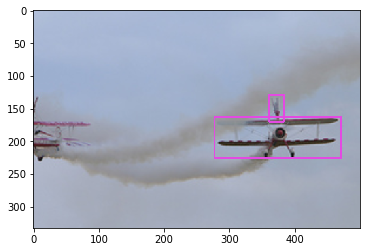

In [60]:
img,bb,_=Scale(1.8)(im.copy(),boxes,np.ones_like(boxes[:,0]))
plt.imshow(draw_rect(img,bb))
bb

## Rotate

In [62]:
class Rotate(object):
    """
    旋转图像
    """

    def __init__(self, angle):
        self.angle = angle

    @classmethod
    def get_new_boxes(cls, height, width, gt_boxes, matrix):
        """

        :param height:
        :param width:
        :param gt_boxes:
        :param matrix:
        :return:
        """
        num_boxes = len(gt_boxes)
        # 每个通道代表一个gt box的mask
        mask = np.zeros(shape=(height, width, num_boxes), dtype=np.uint8)
        for i, box in enumerate(gt_boxes):
            y1, x1, y2, x2 = box
            # float 转 int
            y1, y2 = int(np.floor(y1)), int(np.ceil(y2))
            x1, x2 = int(np.floor(x1)), int(np.ceil(x2))
            mask[y1:y2, x1:x2, i] = 1

        # mask做仿射变换
        new_mask = cv2.warpAffine(mask,
                                  M=matrix,
                                  dsize=(width, height),
                                  borderMode=cv2.BORDER_CONSTANT,
                                  borderValue=(0, 0, 0))
        new_mask = new_mask.astype(np.uint8)

        # 根据变换后的mask值获取新的gt box坐标
        new_gt_boxes = np.zeros_like(gt_boxes)
        for i in range(num_boxes):
            hs, ws = np.where(new_mask[:, :, i] == 1)
            y1, x1, y2, x2 = 0, 0, 0, 0
            if len(hs) > 0:
                y1, y2 = np.min(hs), np.max(hs)
            if len(ws) > 0:
                x1, x2 = np.min(ws), np.max(ws)
            new_gt_boxes[i] = np.array([y1, x1, y2, x2])

        return new_gt_boxes

    def __call__(self, image, gt_boxes=None, labels=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: GT boxes [N,(y1,x1,y2,x2)]
        :param labels: [N]
        :return:
        """
        img_height, img_width = image.shape[:2]

        matrix = cv2.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                                         angle=self.angle,
                                         scale=1)

        # 旋转图像
        image = cv2.warpAffine(image,
                               M=matrix,
                               dsize=(img_width, img_height))

        if gt_boxes is None:
            return image

        boxes = gt_boxes.copy()
        boxes = self.get_new_boxes(img_height, img_width, boxes, matrix)

        # 过滤中心点不在图像内的边框
        keep = center_filter(boxes, [0, 0, img_height, img_width])
        boxes = boxes[keep]
        labels = labels[keep]

        return image, boxes, labels



array([[  0., 212.,  81., 251.],
       [181., 217., 289., 252.],
       [ 20., 246.,  34., 269.],
       [228., 248., 240., 271.]])

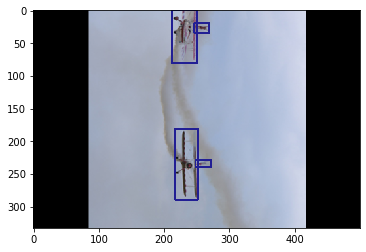

In [65]:
img,bb,_=Rotate(-90)(im.copy(),boxes,np.ones_like(boxes[:,0]))
plt.imshow(draw_rect(img,bb))
bb

## RandomSampleCrop

In [359]:
class RandomSampleCrop(object):
    def __init__(self, ar_range=(1 / 2, 2), min_size=0.3, max_tries=50, clip_boxes=True):
        """

        :param ar_range: 
        :param min_size:
        """
        self.min_aspect_ratio = ar_range[0]
        self.max_aspect_ratio = ar_range[1]
        self.min_size = min_size
        self.max_tries = max_tries
        self.clip_boxes = clip_boxes
        self.sample_options = (
            1.,  # 返回原图
            0.1, 0.3, 0.5, 0.7, 0.9,  # iou最小值
            0.  # 随机裁剪
        )

    def __call__(self, image, gt_boxes=None, labels=None):
        img_height, img_width = image.shape[:2]
        while True:
            # 随机选择一种模式
            mode = random.choice(self.sample_options)
            # 返回原图
            if mode == 1:
                return image, gt_boxes, labels

            min_iou = mode
            # 最多尝试次数
            for _ in range(self.max_tries):
                cur_image = image
                # 采样裁剪后图像长宽
                w = random.uniform(self.min_size * img_width, img_width)
                h = random.uniform(self.min_size * img_height, img_height)

                # 长宽比是否满足要求
                if h / w < self.min_aspect_ratio or h / w > self.max_aspect_ratio:
                    continue

                # 采样裁剪后图像左上顶点坐标
                left = random.uniform(0, img_width - w)
                top = random.uniform(0, img_height - h)
                rect = np.array([int(left), int(top), int(left + w), int(top + h)])
                y1, x1, y2, x2 = rect
                cur_image = cur_image[y1:y2, x1:x2]

                # 如果没有GT Boxes;直接返回裁剪后的图像
                if gt_boxes is None or len(gt_boxes) == 0:
                    return cur_image, gt_boxes, labels

                boxes = gt_boxes.copy()
                cur_labels = labels

                # 过滤中心点不在图像内的边框
#                 keep = center_filter(boxes, rect)
#                 boxes = boxes[keep]
#                 cur_labels = cur_labels[keep]
                
                # 没有gt boxes,重新
                if len(boxes) == 0:
                    continue
                # 计算iou
                keep = iou_filter(boxes, rect, min_iou=min_iou)

                # 最小iou不满足条件，重来
                if not np.all(keep):
                    continue

                boxes = boxes[keep]
                cur_labels = cur_labels[keep]

                # 裁剪gt boxes 到图像内
                if self.clip_boxes:
                    boxes[:, [1, 3]] = np.clip(boxes[:, [1, 3]], a_min=x1, a_max=x2)
                    boxes[:, [0, 2]] = np.clip(boxes[:, [0, 2]], a_min=y1, a_max=y2)
                # 平移boxes
                boxes[:, [1, 3]] -= x1
                boxes[:, [0, 2]] -= y1

                return cur_image, boxes, cur_labels


array([[401., 240., 443., 299.],
       [401., 190., 435., 249.],
       [399., 185., 448., 218.],
       [394.,  99., 433., 163.]])

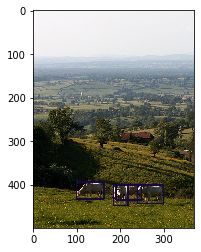

In [394]:
img,bb,_=RandomSampleCrop(clip_boxes=False)(im.copy(),boxes,np.ones_like(boxes[:,0]))
plt.imshow(draw_rect(img,bb))
bb

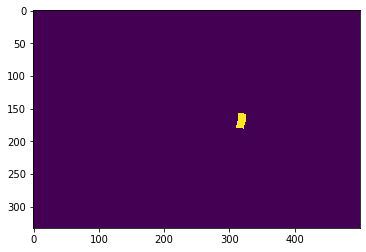

In [245]:
plt.imshow(mask[:,:,3])

## Affine

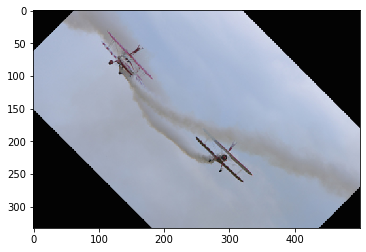

In [8]:
img_height, img_width = im.shape[:2]

# Compute the rotation matrix.
M = cv2.getRotationMatrix2D(center=(img_width / 2, img_height / 2),
                            angle=-45,
                            scale=1)

# Scale the image.
image = cv2.warpAffine(im.copy(),
                       M=M,
                       dsize=(img_width, img_height),
                       borderMode=cv2.BORDER_CONSTANT,
                       borderValue=(3,3,3))
plt.imshow(image)

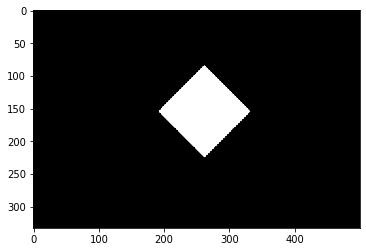

In [18]:
a=np.zeros([300,400,8])
a[100:200,200:300]=1
x=cv2.warpAffine(a,
                       M=M,
                       dsize=(img_width, img_height),
                       borderMode=cv2.BORDER_CONSTANT,
                       borderValue=(0,0,0))
plt.imshow(x[:,:,2:5])

In [22]:
hs,ws=np.where(x[:,:,3]==1)
y1, y2 = np.min(hs), np.max(hs)
x1, x2 = np.min(ws), np.max(ws)
print(y1,x1,y2,x2)

85 192 223 331


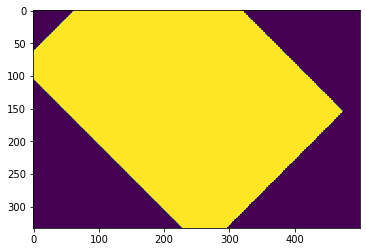

In [17]:
plt.imshow(x[:,:,7])

In [91]:
hs

array([  0,   0,   0, ..., 332, 332, 332])